In [35]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, clear_output

import folium
from folium.plugins import MarkerCluster

In [36]:
df = pd.read_csv('Brazilian_ecommerce (merged).csv', index_col = 0)

In [37]:
df.order_status.unique()

array(['delivered', 'canceled'], dtype=object)

In [38]:
df['sales'] = df['price'] * df['items_count']

for col in df.columns:
    if col.endswith('_timestamp') or col.endswith('_date') or col.endswith('_at'):
        try:
            if col.endswith('_timestamp'):
                df[col] = pd.to_datetime(df[col])
            elif col.endswith('_date') or col.endswith('_at'):
                df[col] = pd.to_datetime(df[col]).dt.date
                df[col] = pd.to_datetime(df[col]).dt.to_period('M')
        except Exception as e:
            print(f'Error mengonversi kolom {col}: {e}')
            pass

display(df.head())
display(df.info())

,order_id,items_count,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_id,shipping_limit_date,price,freight_value,product_cat_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,sales
1,00018f77f2f0320c557190d7a144bdd3,1,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04,2017-05,2017-05,2017-05,dd7ddc04e1b6c2c614352b383efe2d36,2017-05,239.90,19.93,pet_shop,56,239,2,30000,50,30,40,1,credit_card,3,259,4,2017-05,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045,239.90
2,000229ec398224ef6ca0657da4fc703e,1,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01,2018-01,2018-01,2018-02,5b51032eddd242adc84c38acab88f23d,2018-01,199.00,17.87,furniture_decor,59,695,2,3050,33,13,33,1,credit_card,5,216,5,2018-01,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08,2018-08,2018-08,2018-08,9d7a1d34a5052409006425275ba1c2b4,2018-08,12.99,12.79,perfumery,42,480,1,200,16,10,15,1,credit_card,2,25,4,2018-08,2018-08-15 16:39:01,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02,2017-02,2017-03,2017-03,df560393f3a51e74553ab94004ba5c87,2017-02,199.90,18.14,garden_tools,59,409,1,3750,35,40,30,1,credit_card,3,218,5,2017-03,2017-03-03 10:54:59,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438,199.90
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,816cbea969fe5b689b39cfc97a506742,delivered,2017-05-15 21:42:34,2017-05,2017-05,2017-05,2017-06,6426d21aca402a131fc0a5d0960a3c90,2017-05,21.90,12.69,housewares,36,558,1,450,24,8,15,1,boleto,1,34,4,2017-05,2017-05-24 19:00:09,85c835d128beae5b4ce8602c491bf385,38017,uberaba,MG,-19.740324,-47.925353,14091,ribeirao preto,SP,-21.189678,-47.788330,21.90


<class 'pandas.core.frame.DataFrame'>
Index: 93100 entries, 1 to 96459
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93100 non-null  object        
 1   items_count                    93100 non-null  int64         
 2   customer_id                    93100 non-null  object        
 3   order_status                   93100 non-null  object        
 4   order_purchase_timestamp       93100 non-null  datetime64[ns]
 5   order_approved_at              93100 non-null  period[M]     
 6   order_delivered_carrier_date   93100 non-null  period[M]     
 7   order_delivered_customer_date  93100 non-null  period[M]     
 8   order_estimated_delivery_date  93100 non-null  period[M]     
 9   seller_id                      93100 non-null  object        
 10  shipping_limit_date            93100 non-null  period[M]     
 11  price               

None

In [39]:
class SellerAnalysis:
    def __init__(self, seller_id, df):
        self.seller_id = seller_id
        self.df = df
        self.seller_data = df[df['seller_id'] ==  seller_id].copy()

        if self.seller_data.empty:
            print(f'Tidak ada data untuk seller ID {self.seller_id}.')
            self.seller_city = None
            self.seller_prod_category = None
        else:
            self.seller_city = self.seller_data.seller_city.unique()[0]
            self.seller_prod_category = self.seller_data.product_cat_name.value_counts().index.to_list()
            # self.seller_data['sales'] = self.seller_data['price'] * self.seller_data['items_count']

    def plot_sales(self):
        if self.seller_city is None:
            return

        while True:
            # Display menu for product category selection
            print('Choose product category for sales plot:')
            for i, product in enumerate(self.seller_prod_category, 1):
                print(f'{i}. {product}')
            print(f'{len(self.seller_prod_category) + 1}. Exit')

            # Get user input
            try:
                choice = int(input('Enter the number of your choice: '))
                if choice ==  len(self.seller_prod_category) + 1:
                    print('Exiting sales plot...')
                    break
                elif 1 <= choice <= len(self.seller_prod_category):
                    selected_category = self.seller_prod_category[choice - 1]

                    # Seller's product sales in the selected category
                    category_data_seller = self.seller_data[self.seller_data['product_cat_name'] ==  selected_category]
                    category_sales_seller = category_data_seller.groupby('order_purchase_timestamp')['sales'].sum().resample('M').mean()

                    # All sellers' sales in the selected category and city
                    category_data_all = self.df[(self.df['product_cat_name'] ==  selected_category) & (self.df['seller_city'] ==  self.seller_city)]
                    category_sales_all = category_data_all.groupby('order_purchase_timestamp')['sales'].sum().resample('M').mean()

                    # Plotting
                    plt.figure(figsize = (10, 6))
                    plt.plot(category_sales_seller.index, category_sales_seller, 
                             label = f'Seller {self.seller_id}',
                             linewidth = 2)
                    plt.plot(category_sales_all.index, category_sales_all, label = f'All Sellers in {self.seller_city}')

                    plt.title(f'Sales Comparison for Product: {selected_category}')
                    plt.xlabel('Date')
                    plt.ylabel('Total Sales (Price)')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                else:
                    print('Invalid choice, please try again.')
            except ValueError:
                print('Please enter a valid number.')

    def plot_quantity(self):
        if self.seller_city is None:
            return

        while True:
            print('Choose product category for quantity plot:')
            for i, product in enumerate(self.seller_prod_category, 1):
                print(f'{i}. {product}')
            print(f'{len(self.seller_prod_category) + 1}. Exit')

            try:
                choice = int(input('Enter the number of your choice: '))
                if choice ==  len(self.seller_prod_category) + 1:
                    print('Exiting quantity plot...')
                    break
                elif 1 <= choice <= len(self.seller_prod_category):
                    selected_category = self.seller_prod_category[choice - 1]

                    # Seller's quantity sold in the selected category
                    category_data_seller = self.seller_data[self.seller_data['product_cat_name'] == selected_category]
                    category_quantity_seller = category_data_seller.groupby('order_purchase_timestamp')['items_count'].sum().resample('M').sum()

                    # All sellers' quantity sold in the selected category and city
                    category_data_all = self.df[(self.df['product_cat_name'] ==  selected_category) & (self.df['seller_city'] ==  self.seller_city)]
                    category_quantity_all = category_data_all.groupby('order_purchase_timestamp')['items_count'].sum().resample('M').sum()

                    # Plotting
                    plt.figure(figsize = (10, 6))
                    plt.plot(category_quantity_seller.index, category_quantity_seller, 
                             label = f'Seller {self.seller_id}',
                             linewidth = 3)
                    plt.plot(category_quantity_all.index, category_quantity_all, 
                             label = f'All Sellers in {self.seller_city}')

                    plt.title(f'Quantity Comparison for Product: {selected_category}')
                    plt.xlabel('Date')
                    plt.ylabel('Number of Items Sold')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                else:
                    print('Invalid choice, please try again.')
            except ValueError:
                print('Please enter a valid number.')

    def plot_ratings(self):
        if self.seller_city is None:
            return

        while True:
            print('Choose product category for ratings plot:')
            for i, product in enumerate(self.seller_prod_category, 1):
                print(f'{i}. {product}')
            print(f'{len(self.seller_prod_category) + 1}. Exit')

            try:
                choice = int(input('Enter the number of your choice: '))
                if choice ==  len(self.seller_prod_category) + 1:
                    print('Exiting ratings plot...')
                    break
                elif 1 <= choice <= len(self.seller_prod_category):
                    selected_category = self.seller_prod_category[choice - 1]

                    # Seller's ratings in the selected category
                    category_data_seller = self.seller_data[self.seller_data['product_cat_name'] ==  selected_category]
                    category_rating_seller = category_data_seller.groupby('order_purchase_timestamp')['review_score'].mean().resample('M').mean()

                    # All sellers' ratings in the selected category and city
                    category_data_all = self.df[(self.df['product_cat_name'] ==  selected_category) & (self.df['seller_city'] ==  self.seller_city)]
                    category_rating_all = category_data_all.groupby('order_purchase_timestamp')['review_score'].mean().resample('M').mean()

                    # Plotting
                    plt.figure(figsize = (10, 6))
                    plt.plot(category_rating_seller.index, category_rating_seller, label = f'Seller {self.seller_id}')
                    plt.plot(category_rating_all.index, category_rating_all, label = f'All Sellers in {self.seller_city}')

                    plt.title(f'Rating Comparison for Product: {selected_category}')
                    plt.xlabel('Date')
                    plt.ylabel('Average Rating')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                else:
                    print('Invalid choice, please try again.')
            except ValueError:
                print('Please enter a valid number.')
    
    def map_customer_locations(self):
        customer_locations = self.seller_data[['customer_lat', 'customer_lng', 'sales', 'product_cat_name']].dropna()

        if not customer_locations.empty:
            
            # Center the map on the average customer location
            m = folium.Map(location = [customer_locations['customer_lat'].mean(), customer_locations['customer_lng'].mean()], zoom_start = 8)

            marker_cluster = MarkerCluster().add_to(m)

            for _, row in customer_locations.iterrows():
                folium.Marker(
                    location = [row['customer_lat'], row['customer_lng']],
                    popup = f'Total Sales: {row.sales:.2f}<br>Product Category: {row.product_cat_name}',
                    icon = folium.Icon(color = 'green')
                ).add_to(marker_cluster)

            display(m)
        else:
            print('There is no customer location data for this seller.')

In [40]:
df.sample(5).seller_id

73346    4a3ca9315b744ce9f8e9374361493884
39026    f262cbc1c910c83959f849465454ddd3
12620    cca3071e3e9bb7d12640c9fbe2301306
5835     cfb1a033743668a192316f3c6d1d2671
14650    1ca7077d890b907f89be8c954a02686a
Name: seller_id, dtype: object

In [41]:
sa = SellerAnalysis('e9779976487b77c6d4ac45f75ec7afe9', df)
# sa = SellerAnalysis('00ee68308b45bc5e2660cd833c3f81cc', df)

# sa = SellerAnalysis('86ccac0b835037332a596a33b6949ee1', df)

Choose product category for ratings plot:
1. sports_leisure
2. drinks
3. health_beauty
4. food
5. food_drink
6. perfumery
7. housewares
8. pet_shop
9. Exit


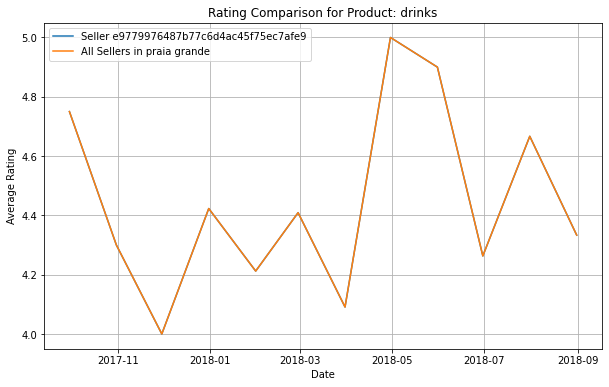

Choose product category for ratings plot:
1. sports_leisure
2. drinks
3. health_beauty
4. food
5. food_drink
6. perfumery
7. housewares
8. pet_shop
9. Exit


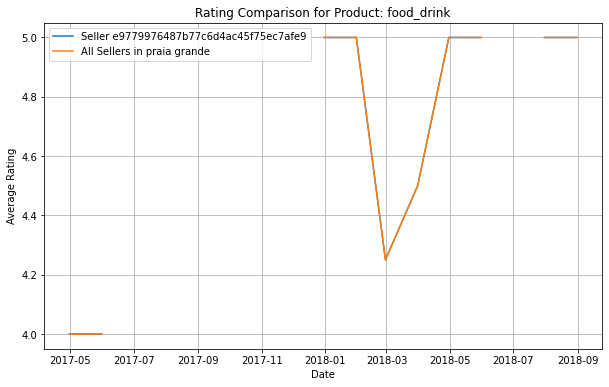

Choose product category for ratings plot:
1. sports_leisure
2. drinks
3. health_beauty
4. food
5. food_drink
6. perfumery
7. housewares
8. pet_shop
9. Exit
Exiting ratings plot...


In [46]:
# sa.seller_data

# sa.plot_sales()
# sa.plot_quantity()
sa.plot_ratings()
# sa.map_customer_locations()